## Install the Required Libraries📥💻🔧

In [ ]:
! pip install open-clip-torch chromadb matplotlib pillow

In [ ]:
# IPEX Installation for Using Intel GPU
! pip install torch==2.3.1+cxx11.abi torchvision==0.18.1+cxx11.abi torchaudio==2.3.1+cxx11.abi intel-extension-for-pytorch==2.3.110+xpu oneccl_bind_pt==2.3.100+xpu --extra-index-url https://pytorch-extension.intel.com/release-whl/stable/xpu/cn/

## Importing Required Libraries📥📚🔗

In [26]:
import torch
import intel_extension_for_pytorch as ipex
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt


- **torch**: PyTorch for device handling and tensor operations.
- **intel_extension_for_pytorch (ipex)**: Intel optimizations for PyTorch (if available, for use with XPU).
- **chromadb**: ChromaDB for managing the vector database.
- **OpenCLIPEmbeddingFunction and ImageLoader**: For handling multimodal data and embeddings.


## Device Setup🔧💻

In [27]:
def get_device() -> torch.device:
    """Check and return the appropriate device (XPU, CUDA, or CPU)."""
    if torch.cuda.is_available():
        device_type = "cuda"
        device = torch.device(device_type)
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    elif torch.xpu.is_available():
        device_type = "xpu"
        device = torch.device(device_type)
        torch.xpu.empty_cache()  # Empty the XPU cache if using XPU
        print(f"Using device: {torch.xpu.get_device_name()}")
    else:
        device_type = "cpu"
        device = torch.device(device_type)
        print("Using CPU")
        
    return device

The `get_device()` function checks for the availability of different devices (CUDA, XPU, or CPU) and returns the appropriate device for computation.

#### Functionality:
- **CUDA Availability Check**: 
  The function first checks if a CUDA-capable GPU is available using `torch.cuda.is_available()`. If CUDA is available, it selects the GPU as the device and prints the name of the GPU.
  
- **XPU Availability Check**: 
  If CUDA is not available, the function checks if an XPU (Accelerator) is available using `torch.xpu.is_available()`. If XPU is available, it selects the XPU device and empties the XPU cache to ensure no previous memory is used.
  
- **Fallback to CPU**: 
  If neither CUDA nor XPU is available, the function defaults to using the CPU as the device and prints "Using CPU".

#### Output:
- The function prints the device being used, which can be either a CUDA-capable GPU, an XPU, or the CPU.
- It returns a `torch.device` object that points to the selected device.


## Initializing Chroma Client⚙️🔌🖥️

In [28]:
def initialize_chroma() -> chromadb.PersistentClient:
    """Initialize Chroma client and return the client object."""
    return chromadb.PersistentClient(path="my_vectordb")

The `initialize_chroma()` function initializes a Chroma client for interacting with a vector database and returns the client object.

#### Functionality:
- **Chroma Client Initialization**: 
  The function creates and initializes a Chroma client using the `chromadb.PersistentClient()` class. The client is configured to use a persistent storage path, `"my_vectordb"`, where the vector data will be stored.
  
- **Return Value**: 
  The function returns the initialized Chroma client object, which can be used for managing and querying the vector database.

#### Output:
- The function returns a `chromadb.PersistentClient` object that is ready for use in performing operations on the Chroma vector database.

## Initializing Database Collection⚙️📚💾

In [29]:
def initialize_db(chroma_client: chromadb.PersistentClient) -> chromadb.Collection:
    """Create and return a multimodal database collection."""
    image_loader = ImageLoader()
    multimodal_ef = OpenCLIPEmbeddingFunction()

    return chroma_client.get_or_create_collection(
        name="multimodal_db",
        embedding_function=multimodal_ef,
        data_loader=image_loader
    )

The `initialize_db()` function creates and returns a multimodal database collection using the provided Chroma client. It sets up the collection with an embedding function and data loader for handling multimodal data (e.g., images and text).

#### Functionality:
- **Image Loader**: 
  The function initializes an `ImageLoader` instance, which is responsible for loading image data that will be stored in the database.
  
- **Embedding Function**: 
  It initializes the `OpenCLIPEmbeddingFunction`, which is used to generate embeddings for multimodal data (images, text, etc.). This function processes the data and creates a suitable representation for storage and retrieval in the vector database.
  
- **Database Collection Creation**: 
  The function calls the `get_or_create_collection` method of the Chroma client to create a collection named `"multimodal_db"`. The collection is set up with the specified embedding function (`multimodal_ef`) and data loader (`image_loader`), enabling the storage and retrieval of multimodal data.

#### Output:
- The function returns a `chromadb.Collection` object that represents the multimodal database collection, ready for storing and querying data.


## Adding Images to Database🖼️💾

In [35]:
def add_images_to_db(multimodal_db: chromadb.Collection):
    """Add sample images to the multimodal database."""
    image_ids = ['0', '1', '2', '3', '4']
    image_uris = [
        'Buildings.jpg', 'Bike.jpeg', 'Ship.jpg',
        'Airplane.jpg', 'Car.jpg'
    ]
    image_metadatas = [
        {'img_category': 'house'}, {'img_category': 'vehicle'},
        {'img_category': 'vehicle'}, {'img_category': 'vehicle'},
        {'img_category': 'vehicle'}
    ]

    # Ensure each image has a unique id and appropriate metadata
    multimodal_db.add(ids=image_ids, uris=image_uris, metadatas=image_metadatas)


The `add_images_to_db()` function adds a set of sample images to the multimodal database collection. The images are accompanied by unique IDs and metadata that describe the image categories.

#### Functionality:
- **Image Data**: 
  The function defines a list of image IDs, URIs (paths to image files), and metadata for five sample images. Each image is categorized into different groups, such as "house" and "vehicle".

- **Adding Data to Database**: 
  The function uses the `add()` method of the `multimodal_db` (a Chroma collection) to add the images to the database. The images are added along with their respective IDs, file URIs, and metadata.

- **Metadata**: 
  The metadata for each image includes an `img_category` key that categorizes the images (e.g., house, vehicle).

#### Output:
- The function adds the provided images to the Chroma collection, which allows for efficient storage, retrieval, and querying of the images based on their IDs, URIs, and metadata.

## Query Results Formatter🔍📊

In [36]:
def print_query_results(query_list: list, query_results: dict) -> None:
    """Print the results of the query."""
    result_count = len(query_results['ids'][0])

    for i, query in enumerate(query_list):
        print(f'Results for query: {query}')
        
        for j in range(result_count):
            result = query_results['ids'][i][j]
            distance = query_results['distances'][i][j]
            document = query_results['documents'][i][j]
            uri = query_results['uris'][i][j]
            data = query_results['data'][i][j]
            
            print(f'id: {result}, distance: {distance}, document: {document}')
            print(f'data: {uri}')

            # Display the image
            plt.imshow(data)
            plt.axis("off")
            plt.show()


The `print_query_results()` function prints the results of a query to a multimodal database, including details like image IDs, distances, documents, and associated metadata. Additionally, it visualizes image data retrieved by the query.

#### Functionality:
- **Query Results Extraction**: 
  The function takes a list of queries (`query_list`) and their corresponding results (`query_results`), where the results are stored in a dictionary format. The function extracts key information from the query results, including image IDs, distances, associated documents, URIs, and the image data itself.

- **Result Display**: 
  For each query in the `query_list`, the function iterates through the results and prints:
  - **ID**: The unique identifier of the image.
  - **Distance**: The distance metric (often used to determine similarity).
  - **Document**: The associated document or description for the image.
  - **URI**: The path or location of the image.

- **Image Visualization**: 
  After printing the results, the function displays the image data using Matplotlib (`plt.imshow(data)`). The image is displayed without axis labels (`plt.axis("off")`), providing a clean view of the image content.

#### Output:
- The function prints the results for each query, showing the image's ID, distance, document, and URI.
- It also displays the image associated with each result in a pop-up window.

## Querying the Database💾🔎

In [37]:
def query_db(multimodal_db: chromadb.Collection, query_texts: list, category_filter: str = None) -> dict:
    """Query the multimodal database and return the results."""
    filters = {'img_category': category_filter} if category_filter else {}
    
    return multimodal_db.query(
        query_texts=query_texts,
        n_results=1,
        include=['documents', 'distances', 'metadatas', 'data', 'uris'],
        where=filters
    )

The `query_db()` function queries a multimodal database collection using a list of query texts and an optional category filter. It returns the results, including relevant metadata, image data, and similarity distances.

#### Functionality:
- **Category Filtering**: 
  The function accepts an optional `category_filter` parameter, which can be used to filter the results by the `img_category` metadata. If a category filter is provided (e.g., `vehicle`, `house`), it is applied to the query; otherwise, no filter is applied.

- **Query Execution**: 
  The function utilizes the `query()` method from the Chroma collection (`multimodal_db`) to execute the query. The following parameters are specified:
  - `query_texts`: The list of query texts to search for in the database.
  - `n_results=2`: Limits the results to the top 2 most relevant matches.
  - `include`: Specifies the fields to include in the result, which are:
    - `documents`: Any documents or metadata associated with the results.
    - `distances`: Similarity distances between the query and results.
    - `metadatas`: Additional metadata related to the results.
    - `data`: The image data itself.
    - `uris`: The URIs (paths) of the images.
  - `where=filters`: Applies any category filter (if provided) to the query.

#### Output:
- The function returns a dictionary containing the following fields:
  - **documents**: The documents or metadata associated with the results.
  - **distances**: The similarity distances for each result.
  - **metadatas**: Additional metadata related to the images.
  - **data**: The actual image data (useful for visualization).
  - **uris**: The URIs (paths) of the images.

## Main Execution Block🚀⚙️

In [40]:
def main():
    """Main function to manage the workflow."""
    # Setup device and Chroma client
    device = get_device()
    chroma_client = initialize_chroma()

    # Initialize the multimodal database and add images
    multimodal_db = initialize_db(chroma_client)
    add_images_to_db(multimodal_db)

    # Query the database for results related to 'Airplane' and display results
    query_texts = ['Aeroplane']
    query_results = query_db(multimodal_db, query_texts, category_filter='vehicle')
    print_query_results(query_texts, query_results)

The `main()` function manages the entire workflow of setting up the environment, initializing the multimodal database, adding images, and performing a query. It orchestrates the steps needed to interact with the multimodal database, query it, and display the results.

#### Functionality:
- **Device Setup**: 
  The function begins by calling `get_device()`, which selects the appropriate hardware device (CPU, CUDA, or XPU) for computation based on the system's available resources.

- **Chroma Client Initialization**: 
  It initializes a Chroma client by calling `initialize_chroma()`, which sets up the vector database connection.

- **Multimodal Database Initialization and Image Addition**: 
  The function proceeds by initializing the multimodal database using `initialize_db()` and then adds sample images to the database with `add_images_to_db()`.

- **Query Execution**: 
  It queries the multimodal database with the text "Airplane" by calling `query_db()`, with an optional filter to restrict results to the 'vehicle' category. The function then retrieves the top results and calls `print_query_results()` to display the query results and show relevant images.

- **End of Workflow**: 
  After completing the query and displaying the results, the function prints `"END"` to indicate the end of the process.

#### Output:
- The function prints the query results for the text "Airplane", including image IDs, similarity distances, associated documents, and image URIs.
- It also displays the images that match the query criteria and prints `"END"` when the workflow finishes.

## Running the Program▶️💻🚀

Using device: Intel(R) Data Center GPU Max 1100


Results for query: Aeroplane
id: 3, distance: 1.413382163761307, document: None
data: Airplane.jpg


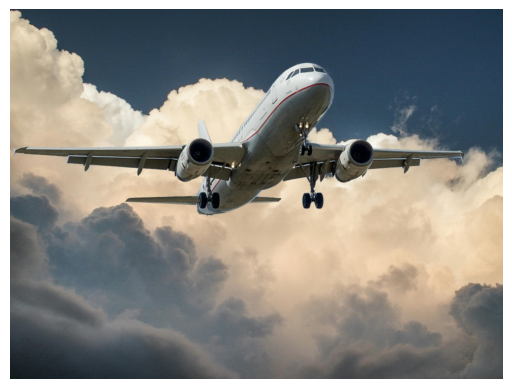

In [41]:
if __name__ == "__main__":
    main()